In [1]:
import numpy as np
import spacy
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

from datasets import load_dataset
from transformers import AutoTokenizer

## Dataset

In [2]:
dataset = load_dataset("imdb", split="train")
num_docs = len(dataset)

Found cached dataset imdb (/Users/Z004MPZ/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


## Tokenizers 

In [3]:
# tokenizer from a hugging-face model (hf)
tokenizer_hf = AutoTokenizer.from_pretrained("bert-base-cased")
def get_tokens_hf(text):
    return [token for token in tokenizer_hf.tokenize(text, max_length=5000, truncation=True)]

get_tokens_hf(dataset[0]['text'])[:10]

['I', 'rented', 'I', 'AM', 'C', '##UR', '##IO', '##US', '-', 'Y']

In [4]:
# tokenizer from a Spacy (sp)
tokenizer_sp = spacy.load ("en_core_web_sm")
def get_tokens_sp(text):
    return [token.text for token in tokenizer_sp(text)]

get_tokens_sp(dataset[0]['text'])[:10]

['I', 'rented', 'I', 'AM', 'CURIOUS', '-', 'YELLOW', 'from', 'my', 'video']

## Tokens to list

In [5]:
## Save the hf tokens 
lst_tokens_hf = [get_tokens_hf(d['text']) for d in dataset]

In [6]:
## Save the sp tokens 
lst_tokens_sp = [get_tokens_sp(d['text']) for d in dataset]

In [7]:
def get_docs_per_token(tokens_per_doc):
    #Only considering present and absent, not the term frequency
    docs_per_token = defaultdict(set)
    for idx, tokens in enumerate(tokens_per_doc):
        for token in tokens:
            docs_per_token[token].add(idx)
    return docs_per_token

In [8]:
dict_tokens_hf = get_docs_per_token(lst_tokens_hf)
print("Total tokens for hf: ", len(dict_tokens_hf))

Total tokens for hf:  25204


In [9]:
dict_tokens_sp = get_docs_per_token(lst_tokens_sp)
print("Total tokens for sp: ", len(dict_tokens_sp))

Total tokens for sp:  121065


#### Num of tokens belonging to N docs

In [10]:
def plot_doc_freq_histo(docs_per_token, doc_thresholds=num_docs, title_txt="bar"):
    doc_freq = [len(docs_per_token[token]) for token in docs_per_token if len(docs_per_token[token]) <= doc_thresholds]
    d = Counter(doc_freq)
    plt.figure(figsize=(10,3))
    plt.xlabel("num docs")
    plt.ylabel("Num of tokens")
    plt.title("{}".format(title_txt))
    plt.bar(d.keys(), d.values())
    plt.show()

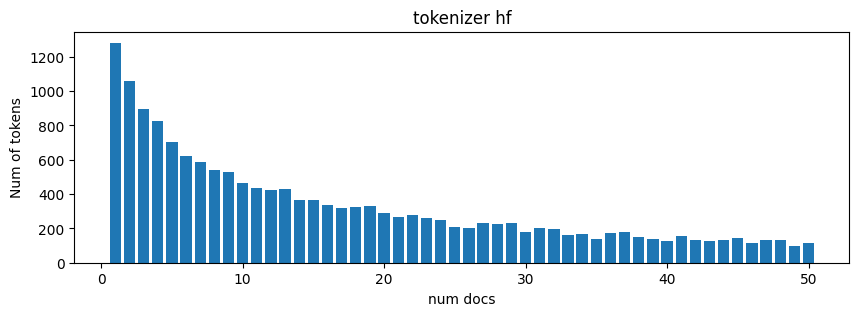

In [11]:
plot_doc_freq_histo(dict_tokens_hf, doc_thresholds=50, title_txt="tokenizer hf")

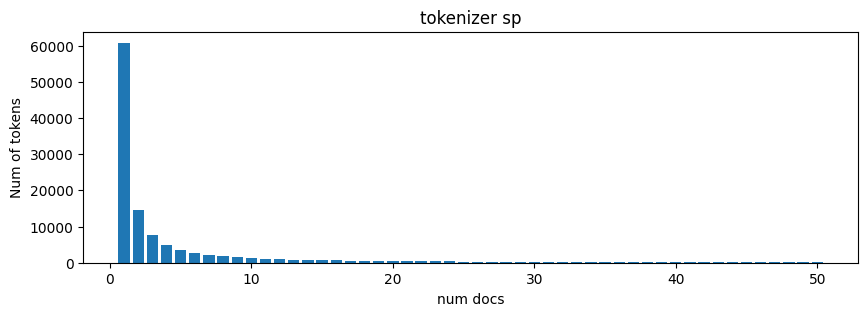

In [12]:
plot_doc_freq_histo(dict_tokens_sp, doc_thresholds=50, title_txt="tokenizer sp")

## Top 1000 tokens based on entropy

In [13]:
# tokens prob 
def get_tokens_prob(docs_per_token):
    tokens_prob = {}
    for token in docs_per_token:
        tokens_prob[token] = {'present':0.0, 'absent':0.0}
        tokens_prob[token]['present'] = len(docs_per_token[token])/num_docs
        tokens_prob[token]['absent'] = 1 - tokens_prob[token]['present']
    return tokens_prob

In [14]:
# compute entropy
def get_tokens_entropy(tokens_prob):
    tokens_entropy = {}
    for token in tokens_prob:
        probs = np.array([tokens_prob[token][v] for v in tokens_prob[token]])
        if 0 in probs:
            tokens_entropy[token] = 0.0
        else:
            tokens_entropy[token] = -np.sum(probs * np.log(probs)) / np.log(2)
    return tokens_entropy

In [15]:
# get top tokens based on entropy
# low entropy tokens
def get_top_tokens(tokens_entropy, N=1000, reverse=True):
    return sorted(tokens_entropy, key=tokens_entropy.get, reverse=reverse)[:N]

In [16]:
# high entrop tokens - hf
tokens_prob_hf = get_tokens_prob(dict_tokens_hf)
tokens_entropy_hf = get_tokens_entropy(tokens_prob_hf)
top_tokens_hf = get_top_tokens(tokens_entropy_hf)
top_dict_tokens_hf = {k:dict_tokens_hf[k] for k in dict_tokens_hf if k in set(top_tokens_hf)}

##sanity check
for token in top_tokens_hf[:20]:
    print(token, tokens_prob_hf[token], tokens_entropy_hf[token])

at {'present': 0.50188, 'absent': 0.49812} 0.9999898018532654
all {'present': 0.50276, 'absent': 0.49724} 0.9999780201408898
an {'present': 0.48512, 'absent': 0.51488} 0.9993610387499637
you {'present': 0.51568, 'absent': 0.48432} 0.9992904747458042
( {'present': 0.53444, 'absent': 0.46556} 0.9965748881966388
" {'present': 0.46492, 'absent': 0.53508} 0.9964463016732859
one {'present': 0.5388, 'absent': 0.46120000000000005} 0.9956518482853632
by {'present': 0.46036, 'absent': 0.53964} 0.9954613396761077
) {'present': 0.5398, 'absent': 0.46020000000000005} 0.9954245877729168
from {'present': 0.45728, 'absent': 0.54272} 0.9947277421791774
like {'present': 0.45664, 'absent': 0.5433600000000001} 0.9945683881824201
It {'present': 0.456, 'absent': 0.544} 0.99440665256278
are {'present': 0.55288, 'absent': 0.44711999999999996} 0.9919164910901836
film {'present': 0.55528, 'absent': 0.44472} 0.9911645470936252
who {'present': 0.44448, 'absent': 0.55552} 0.9910875024772052
so {'present': 0.44092,

In [17]:
# low entropy tokens - hf
bottom_tokens_hf = get_top_tokens(tokens_entropy_hf, reverse=False)
bottom_dict_tokens_hf = {k:dict_tokens_hf[k] for k in dict_tokens_hf if k in set(bottom_tokens_hf)}

##sanity check
for token in bottom_tokens_hf[:20]:
    print(token, tokens_prob_hf[token], tokens_entropy_hf[token])

clit {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
geographically {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Yemen {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
symmetric {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
edible {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Goethe {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
##xham {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Calgary {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
nak {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Domain {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
estimates {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Academic {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Guadalajara {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
smirked {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
WTA {'present': 4e-05, 'absent': 0.99996} 0.000642092266441

In [18]:
# high entrop tokens - sp
tokens_prob_sp = get_tokens_prob(dict_tokens_sp)
tokens_entropy_sp = get_tokens_entropy(tokens_prob_sp)
top_tokens_sp = get_top_tokens(tokens_entropy_sp)
top_dict_tokens_sp = {k:dict_tokens_sp[k] for k in dict_tokens_sp if k in set(top_tokens_sp)}

##sanity check
for token in top_tokens_sp[:20]:
    print(token, tokens_prob_sp[token], tokens_entropy_sp[token])

at {'present': 0.49612, 'absent': 0.50388} 0.999956561747589
all {'present': 0.496, 'absent': 0.504} 0.9999538332662392
( {'present': 0.50664, 'absent': 0.49336} 0.9998727805659272
) {'present': 0.50932, 'absent': 0.49068} 0.9997493535768839
you {'present': 0.5138, 'absent': 0.48619999999999997} 0.9994504365278419
an {'present': 0.47824, 'absent': 0.52176} 0.9986333431245605
one {'present': 0.5352, 'absent': 0.4648} 0.9964219272637145
" {'present': 0.46348, 'absent': 0.53652} 0.9961482962612953
by {'present': 0.45908, 'absent': 0.5409200000000001} 0.995163161148733
from {'present': 0.45672, 'absent': 0.54328} 0.9945884376660962
like {'present': 0.45396, 'absent': 0.5460400000000001} 0.9938752194875712
film {'present': 0.54916, 'absent': 0.45084} 0.9930155832816863
who {'present': 0.442, 'absent': 0.558} 0.9902716614103876
are {'present': 0.5606, 'absent': 0.4394} 0.9893777132202458
be {'present': 0.56184, 'absent': 0.43816} 0.9889374278568404
so {'present': 0.42972, 'absent': 0.57028} 

In [19]:
# low entropy tokens - sp
bottom_tokens_sp = get_top_tokens(tokens_entropy_sp, reverse=False)
bottom_dict_tokens_sp = {k:dict_tokens_sp[k] for k in dict_tokens_sp if k in set(bottom_tokens_sp)}

##sanity check
for token in bottom_tokens_sp[:20]:
    print(token, tokens_prob_sp[token], tokens_entropy_sp[token])

vulvas {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
schlongs {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
clitoris {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
Masculin {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
féminin {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
beckoned {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
schlepped {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
asinie {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
/>Cultural {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
box!<br {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
/>Elite {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
esthetes {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
spewings {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
rhythymed {'present': 4e-05, 'absent': 0.99996} 0.000642092266441667
industry" {'present': 4e-05, 'absent': 0.99996} 0.0

#### Plot entropy changes

In [20]:
def plot_tokens_entropy(tokens_entropy, title_txt="line"):
    sorted_entropy = sorted([(tokens_entropy[token], token) for token in tokens_entropy])
    x = list(range(len(tokens_entropy)))
    y = [y_ for y_, x_ in sorted_entropy]
    plt.figure(figsize=(10,3))
    plt.xlabel("tokens")
    plt.ylabel("entropy")
    plt.title("{}".format(title_txt))
    plt.plot(x, y)
    plt.show()

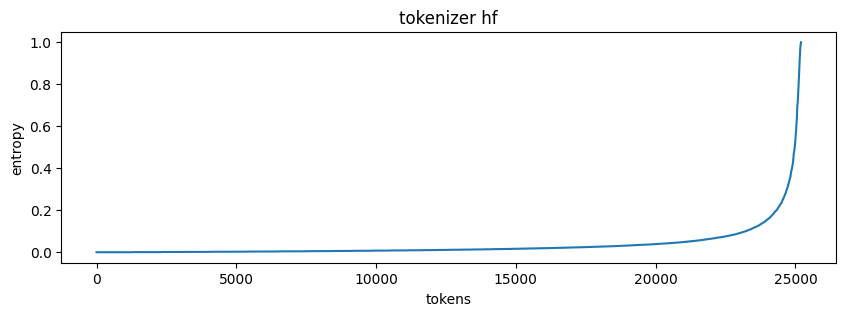

In [21]:
plot_tokens_entropy(tokens_entropy_hf, title_txt="tokenizer hf")

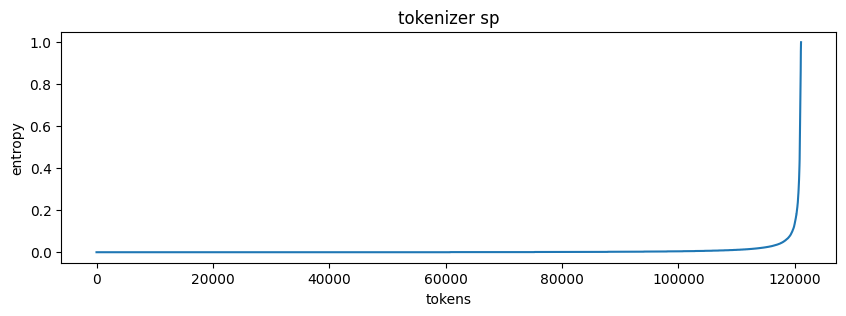

In [22]:
plot_tokens_entropy(tokens_entropy_sp, title_txt="tokenizer sp")

## Compare and Select tokens 

#### Num of tokens belonging to N docs

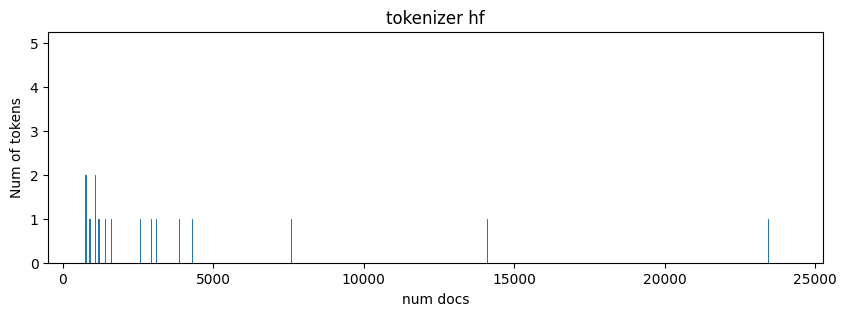

In [23]:
plot_doc_freq_histo(top_dict_tokens_hf, title_txt="tokenizer hf")

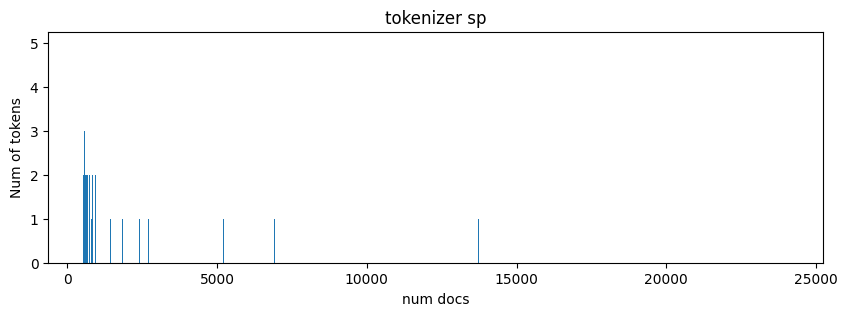

In [24]:
plot_doc_freq_histo(top_dict_tokens_sp, title_txt="tokenizer sp")

In [25]:
# entroy compare
sum_entropy_hf = sum([tokens_entropy_hf[token] for token in top_tokens_hf])
sum_entropy_sp = sum([tokens_entropy_sp[token] for token in top_tokens_sp])
sum_entropy_hf, sum_entropy_sp

(389.54637220464286, 355.18713140803345)

#### Mutual information calulations

In [26]:
def get_labels_prob():
    labels = [d['label'] for d in dataset]
    labels_freq = dict(Counter(labels))
    return {label:labels_freq[label]/num_docs for label in labels_freq}, labels_freq
labels_prob, labels_freq = get_labels_prob()
labels_prob, labels_freq

({0: 0.5, 1: 0.5}, {0: 12500, 1: 12500})

In [27]:
def get_idx_label_map():
    return {idx:label for idx, label in enumerate([d['label'] for d in dataset])}

idx_label_map = get_idx_label_map()

In [28]:
# compute joint probabilities
def get_tokens_jp(docs_per_token):
    tokens_jp = {}
    for token in docs_per_token:
        tokens_jp[token] = {}
        for v in labels_freq:
            tokens_jp[token][('present', v)] = len([1 for idx in docs_per_token[token] if idx_label_map[idx]==v])/num_docs
            tokens_jp[token][('absent', v)] = (labels_freq[v] - tokens_jp[token][('present', v)])/num_docs
    return tokens_jp

In [29]:
# compute mutual information
def get_mutual_information(docs_per_token):
    mi = {}
    tokens_prob = get_tokens_prob(docs_per_token)
    tokens_jp = get_tokens_jp(docs_per_token)
    for token in tokens_jp:
        mi[token] = 0.0
        for token_, label_ in tokens_jp[token]:
            temp = tokens_jp[token][(token_, label_)] / (tokens_prob[token][token_] * labels_prob[label_])
            if temp == 0:
                continue
            mi[token] += (tokens_jp[token][(token_, label_)] * np.log(temp))
        mi[token] /= np.log(2)
    return mi

In [30]:
def get_total_mi(d):
    return sum([d[k] for k in d])

In [31]:
mi_hf = get_mutual_information(top_dict_tokens_hf)
get_total_mi(mi_hf)

209.10320638080412

In [32]:
mi_sp = get_mutual_information(top_dict_tokens_sp)
get_total_mi(mi_sp)

186.81707865709663